In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from scipy.stats import yeojohnson, skew, kurtosis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
input_file_path="/home/zoro/ACM Hackathon 2k25/device_data_model_input(device_data).csv"
target_file_path="/home/zoro/ACM Hackathon 2k25/device_data_model_target(poll_params).csv"
met_params_path="/home/zoro/ACM Hackathon 2k25/device_data_model_target(met_params).csv"

In [3]:
input_data=pd.read_csv(input_file_path)
target_data=pd.read_csv(target_file_path)
met_params_data = pd.read_csv(met_params_path)

## Data Cleaning


In [5]:
# # Converting the Timestamps format for Consistency
# input_data['dt_time'] = pd.to_datetime(input_data['dt_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
# target_data['dt_time'] = pd.to_datetime(target_data['dt_time'], errors='coerce')
# met_params_data['dt_time'] = pd.to_datetime(met_params_data['dt_time'], errors='coerce')


In [6]:
# input_data.info(),target_data.info(),met_params_data.info()

In [7]:
# input_data = input_data.dropna(subset=['dt_time']).sort_values('dt_time').reset_index(drop=True)
# target_data = target_data.dropna(subset=['dt_time']).sort_values('dt_time').reset_index(drop=True)
# met_params_data = met_params_data.dropna(subset=['dt_time']).sort_values('dt_time').reset_index(drop=True)
# input_data.info()

# # Merging the Data using Nearest Join with 1-minute tolerance
# merged_data = pd.merge_asof(input_data, target_data, on='dt_time', direction='nearest', tolerance=pd.Timedelta('1min'))
# merged_data = pd.merge_asof(merged_data, met_params_data, on='dt_time', direction='nearest', tolerance=pd.Timedelta('1min'))
# # Avoid Forward fill for Ozone to preserve original readings
# # Nearest neighbor interpolation for ozone to avoid constant values
# # merged_data['ozone'] = merged_data['ozone'].interpolate(method='spline', order=2)

# # Interpolate non-ozone features only
# non_ozone_cols = [col for col in merged_data.columns if col != 'ozone']
# merged_data[non_ozone_cols] = merged_data[non_ozone_cols].interpolate(method='linear')

# # Remove duplicate timestamps if any
# merged_data = merged_data.drop_duplicates(subset='dt_time')

# # Sort data chronologically after merging
# merged_data = merged_data.sort_values('dt_time').reset_index(drop=True)


# # # Show merged data info
# # samp=merged_data.iloc[10908].tolist()
# merged_data.info()

In [8]:
# input_data['dt_time'] = pd.to_datetime(input_data['dt_time'])
# target_data['dt_time'] = pd.to_datetime(target_data['dt_time'])
# met_params_data['dt_time'] = pd.to_datetime(met_params_data['dt_time'])

# merged_data = input_data.merge(target_data, on='dt_time', how='outer')
# merged_data = merged_data.merge(met_params_data, on='dt_time', how='outer')

# # Sort by dt_time and set it as index
# merged_data = merged_data.sort_values('dt_time').set_index('dt_time')

# # Resample to 1-minute intervals, interpolate missing values
# resampled_data = merged_data.resample('1T').mean()
# interpolated_data = resampled_data.interpolate(method='linear')

# # Reset index to bring dt_time back as a column
# interpolated_data.reset_index(inplace=True)

In [73]:
input_data['dt_time'] = pd.to_datetime(input_data['dt_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
target_data['dt_time'] = pd.to_datetime(target_data['dt_time'], errors='coerce')
met_params_data['dt_time'] = pd.to_datetime(met_params_data['dt_time'], errors='coerce')

# Merge datasets on 'dt_time' using outer join to preserve all records
merged_data = pd.merge(input_data, target_data, on='dt_time', how='outer')
merged_data = pd.merge(merged_data, met_params_data, on='dt_time', how='outer')

# Sort by 'dt_time' for correct temporal order
merged_data.sort_values('dt_time', inplace=True)

# Identify numeric columns (excluding 'dt_time')
numeric_columns = merged_data.columns.difference(['dt_time'])

# Apply linear interpolation to fill missing values
merged_data[numeric_columns] = merged_data[numeric_columns].interpolate(method='linear', limit_direction='both')

# Verify no missing values remain
print(merged_data.isnull().sum())

dt_time     0
op1         0
op2         0
temp        0
humidity    0
ozone       0
ws          0
wd          0
dtype: int64


In [36]:
missing_values = merged_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 dt_time     0
op1         0
op2         0
temp        0
humidity    0
ws          0
wd          0
ozone       0
dtype: int64


In [77]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21133 entries, 0 to 21132
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dt_time   21133 non-null  datetime64[ns]
 1   op1       21133 non-null  float64       
 2   op2       21133 non-null  float64       
 3   temp      21133 non-null  float64       
 4   humidity  21133 non-null  float64       
 5   ozone     21133 non-null  float64       
 6   ws        21133 non-null  float64       
 7   wd        21133 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.3 MB


In [ ]:
samp=merged_data.iloc[13354].tolist()
print(samp)

In [79]:
# Calculate IQR for ozone
Q1 = merged_data['ozone'].quantile(0.25)
Q3 = merged_data['ozone'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
merged_data = merged_data[(merged_data['ozone'] >= lower_bound) & (merged_data['ozone'] <= upper_bound)]

# Reset index after removal
merged_data = merged_data.reset_index(drop=True)
z_scores = (merged_data['ozone'] - merged_data['ozone'].mean()) / merged_data['ozone'].std()
merged_data.loc[np.abs(z_scores) > 2.5, 'ozone'] = np.nan  # Remove extreme outliers

# 2. Identify and smooth step changes (flat lines)
threshold = 0.01  # Set threshold for detecting flat lines
step_mask = merged_data['ozone'].diff().abs() < threshold
merged_data.loc[step_mask, 'ozone'] = np.nan

# 3. Fill missing values after outlier removal using rolling window
merged_data['ozone'] = merged_data['ozone'].interpolate(method='linear')

<Figure size 1500x600 with 0 Axes>

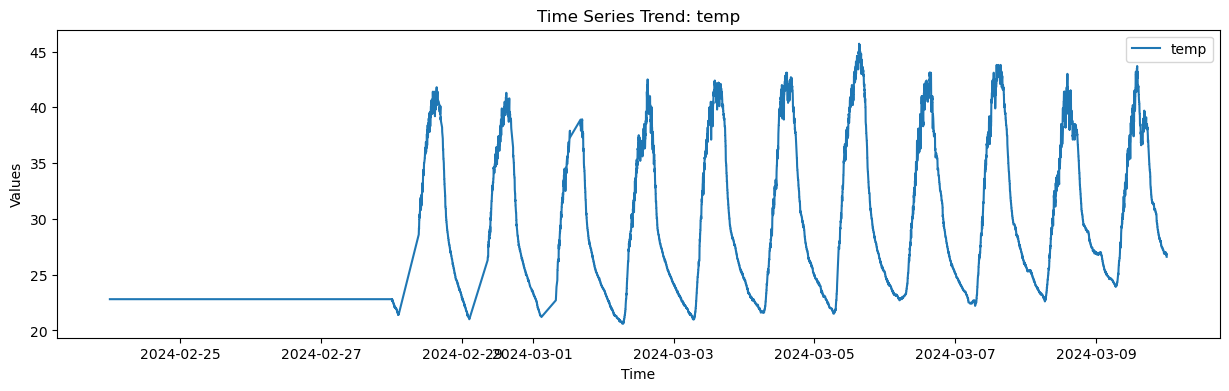

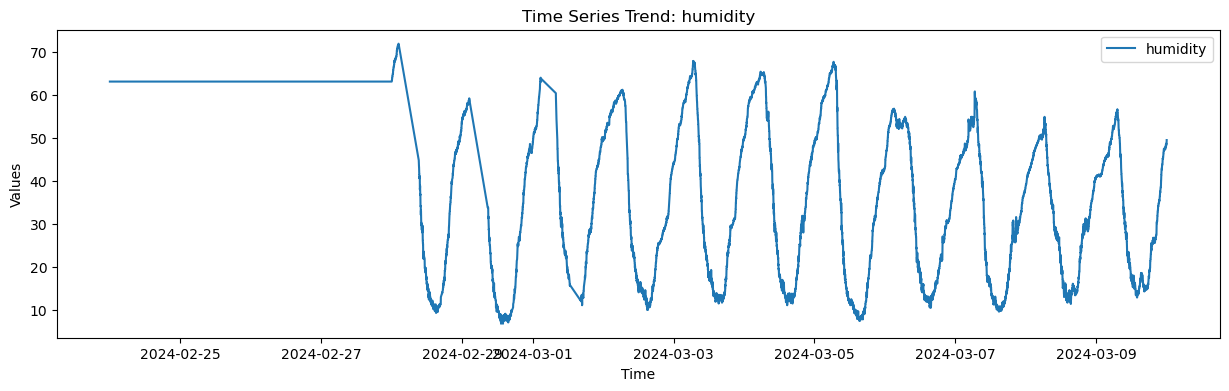

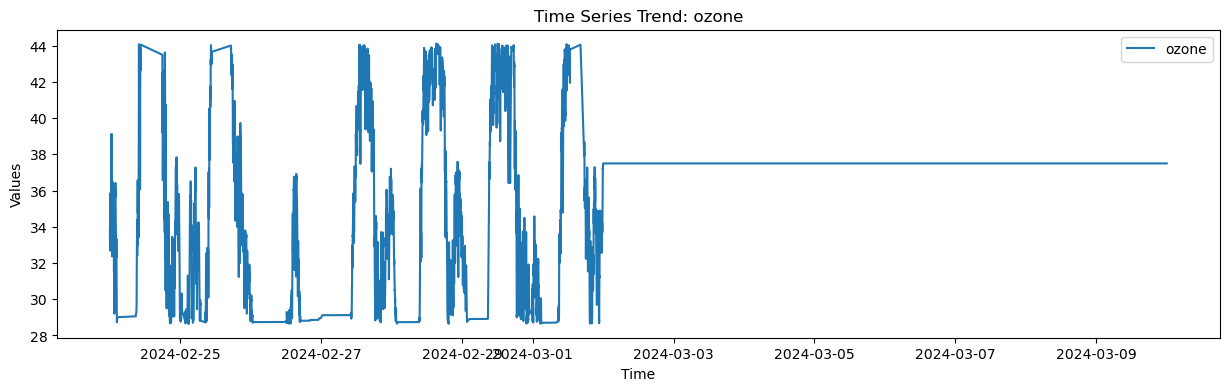

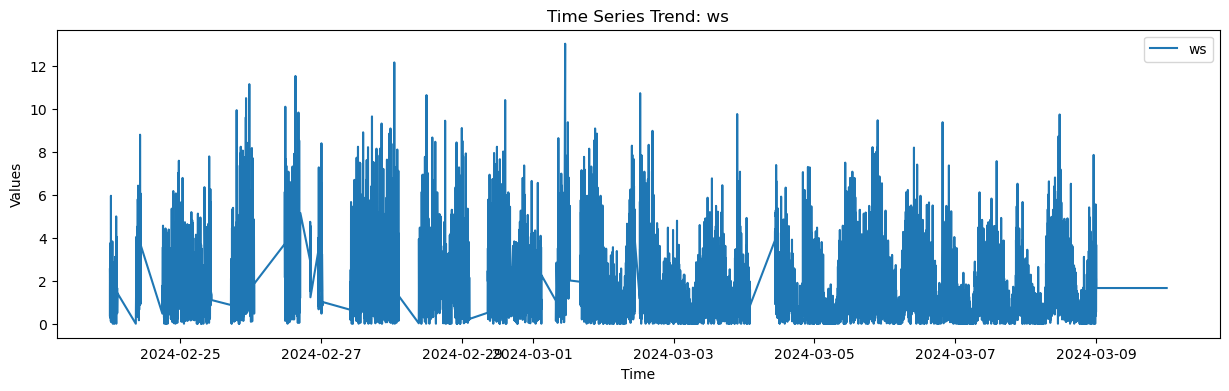

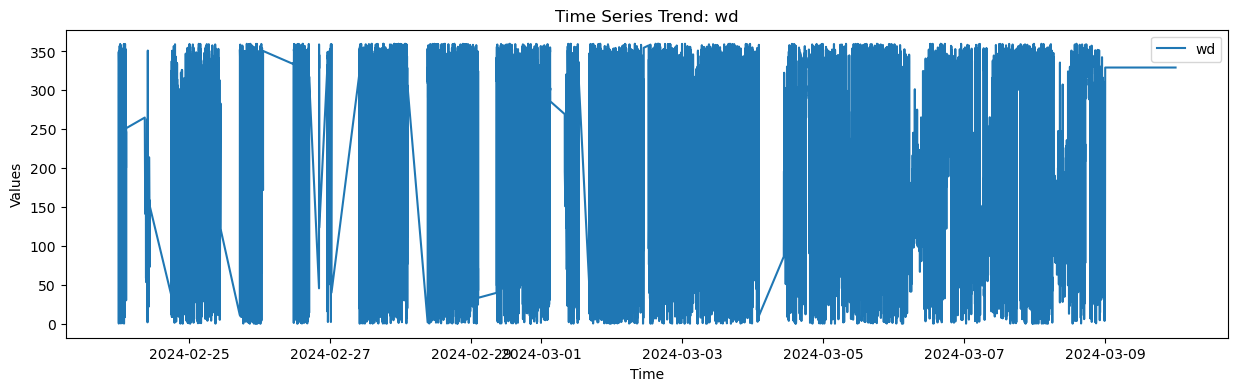

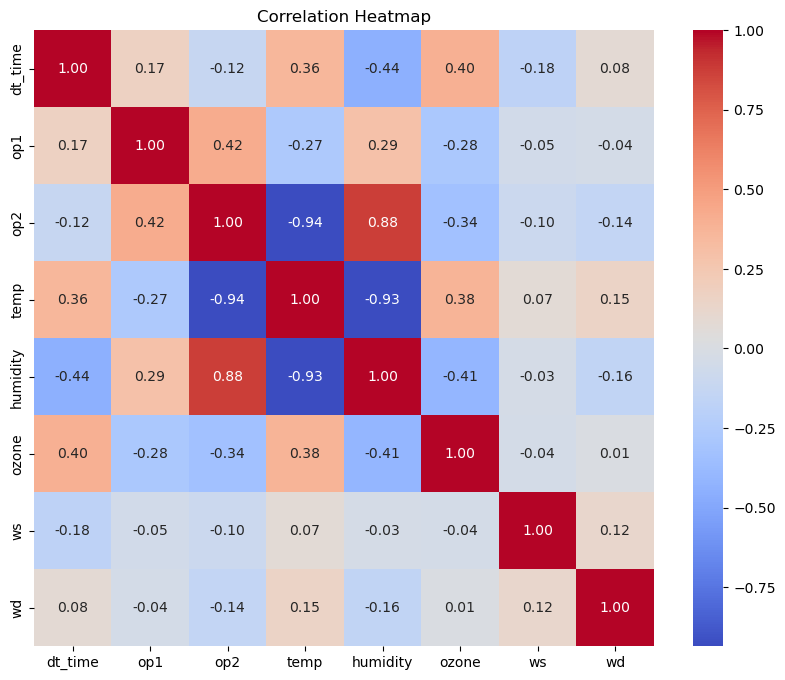

In [81]:
plt.figure(figsize=(15, 6))
columns_to_plot = ['temp', 'humidity', 'ozone', 'ws', 'wd']
for column in columns_to_plot:
    plt.figure(figsize=(15, 4))
    plt.plot(merged_data['dt_time'], merged_data[column], label=column)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f'Time Series Trend: {column}')
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



In [71]:
# Import Libraries
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search Parameter Grids (same as before)
param_grids = {
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7, 9]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7, 9]
    },
    "SVR": {
        "C": [0.1, 1, 10, 100],
        "kernel": ['rbf', 'linear'],
        "gamma": ['scale', 'auto']
    },
    "Neural Network": {
        "hidden_layer_sizes": [(32,), (64,), (128,), (64, 32), (128, 64)],
        "activation": ['relu', 'tanh'],
        "max_iter": [500, 1000, 1500]
    }
}

# Train, Random Search, and Evaluate Models
random_results = {}
for name, model in models.items():
    print(f"Training {name} with Randomized Search...")

    if name in param_grids:
        # Apply Randomized Search
        random_search = RandomizedSearchCV(
            model, 
            param_grids[name], 
            cv=3, 
            scoring='r2', 
            n_iter=20,  # Control the number of parameter combinations
            n_jobs=-1, 
            verbose=1, 
            random_state=42
        )
        
        # Use scaled data for models that need it
        if name in ["SVR", "Neural Network"]:
            random_search.fit(X_train_scaled, y_train)
            best_model = random_search.best_estimator_
            y_pred = best_model.predict(X_test_scaled)
        else:
            random_search.fit(X_train, y_train)
            best_model = random_search.best_estimator_
            y_pred = best_model.predict(X_test)
        
        print(f"Best Params for {name}: {random_search.best_params_}")
    else:
        # Fit the model directly (e.g., Linear Regression)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    random_results[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}

# Display Results
random_results_df = pd.DataFrame(random_results).T.sort_values("R2", ascending=False)
print("Random Search Model Performance:\n", random_results_df)

# Save Results to CSV
random_results_df.to_csv("random_search_results.csv", index=True)
print("Random Search Results saved as random_search_results.csv")


Training Linear Regression with Randomized Search...
Training Gradient Boosting with Randomized Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/zoro/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params for Gradient Boosting: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}
Training Random Forest with Randomized Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Training XGBoost with Randomized Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params for XGBoost: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}
Training SVR with Randomized Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params for SVR: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
Training Neural Network with Randomized Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zoro/anaconda3/lib/python3.12/site-pa

Best Params for Neural Network: {'max_iter': 500, 'hidden_layer_sizes': (32,), 'activation': 'tanh'}
Random Search Model Performance:
                          R2      RMSE       MAE
Neural Network     0.751434  3.302157  2.735688
SVR                0.729628  3.443954  2.864442
Linear Regression  0.701659  3.617702  3.092652
Random Forest      0.633113  4.011829  3.406293
Gradient Boosting  0.631177  4.022404  3.394929
XGBoost            0.628928  4.034644  3.401323
Random Search Results saved as random_search_results.csv


/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [65]:
selected_features = ['temp', 'humidity', 'op2', 'op1', 'ws']
X = merged_data[selected_features]
y = merged_data['ozone']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize the features (important for SVR and Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Parameter Grids
param_grids = {
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "SVR": {
        "C": [0.1, 1, 10],
        "kernel": ['rbf', 'linear'],
        "gamma": ['scale', 'auto']
    },
    "Neural Network": {
        "hidden_layer_sizes": [(64,), (64, 32), (128, 64)],
        "activation": ['relu', 'tanh'],
        "max_iter": [500, 1000]
    }
}

# Models without Grid Search (baseline)
models = {
    "Linear Regression": LinearRegression()
}

# Add models that will undergo Grid Search
models.update({
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "SVR": SVR(),
    "Neural Network": MLPRegressor(random_state=42)
})

# Train, Grid Search, and Evaluate Models
results = {}
for name, model in models.items():
    print(f"Training {name}...")

    if name in param_grids:
        # Apply Grid Search
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='r2', n_jobs=-1, verbose=1)
        
        # Use scaled data for models that need it
        if name in ["SVR", "Neural Network"]:
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test_scaled)
        else:
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
        
        print(f"Best Params for {name}: {grid_search.best_params_}")
    else:
        # Fit the model directly (e.g., Linear Regression)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    results[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}

# Display Results
results_df = pd.DataFrame(results).T.sort_values("R2", ascending=False)
print("Model Performance:\n", results_df)

Training Linear Regression...
Training Gradient Boosting...


NameError: name 'GridSearchCV' is not defined